# Clasificación por departamentos

Primero debemos extraer toda la información disponible.

In [50]:
# Cargamos el buzón de quejas, extraemos las instancias y los detalles de la queja
import pandas as pd
from pathlib import Path

# La carpeta raiz es la superior al directorio actual
carpeta_raiz = Path.cwd().parent
ruta = carpeta_raiz / "Buzón de Quejas, Sugerencias y Felicitaciones (respuestas) (2).xlsx"

# Comprobamos que la ruta exista antes de cargar el archivo
if not ruta.exists():
    raise FileNotFoundError(f"La ruta especificada no existe: {ruta}")
else:
    df = pd.read_excel(ruta)

# Extraemos las columnas relevantes
columnas_relevantes = ["Detalles de la queja, sugerencia o felicitación", "Instancia"]
df_relevante = df[columnas_relevantes].dropna()
print(df_relevante.head())


       Detalles de la queja, sugerencia o felicitación              Instancia
107                                    Mejor internet   Unidad de Informática
108               No hay internet en algunas máquinas   Unidad de Informática
109                              Me gustó los equipos   Unidad de Informática
110  El chico siempre pide llenar la encuesta y me ...  Unidad de Informática
111                                Ninguna, todo bien   Unidad de Informática


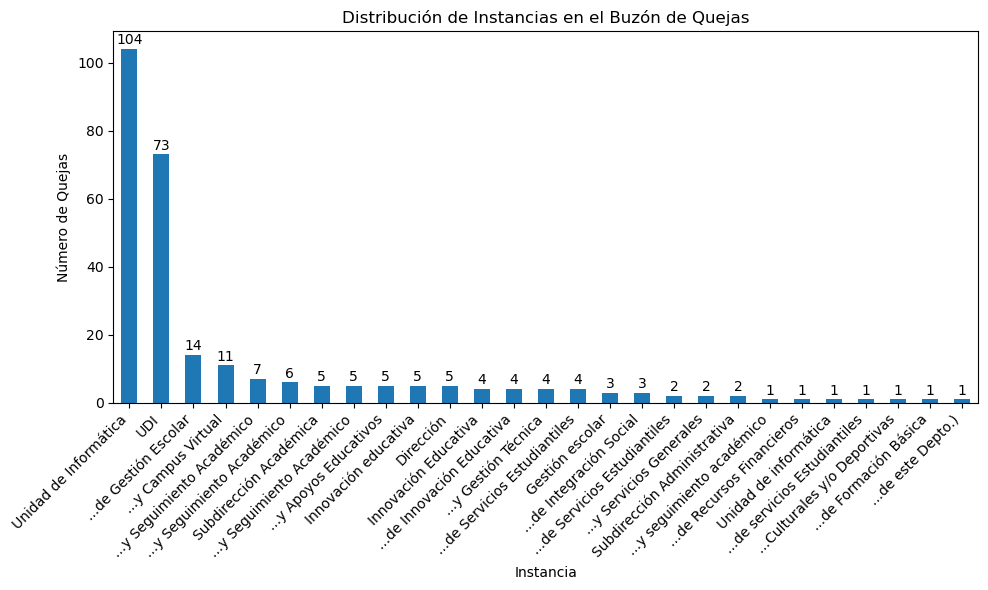

In [51]:
# Función reusable para graficar distribuciones con etiquetas truncadas
import matplotlib.pyplot as plt

def graficar_distribucion(datos, titulo="Distribución", xlabel="Categoría", ylabel="Cantidad", 
                          n_palabras=3, figsize=(10, 6), rotation=45):
    """
    Genera una gráfica de barras con etiquetas truncadas y conteos sobre las barras.
    
    Parámetros:
    -----------
    datos : pd.Series o dict
        Datos a graficar. Si es un diccionario, se convierte a Series.
    titulo : str
        Título del gráfico.
    xlabel : str
        Etiqueta del eje X.
    ylabel : str
        Etiqueta del eje Y.
    n_palabras : int
        Número de palabras a mostrar en las etiquetas del eje X (default: 3).
    figsize : tuple
        Tamaño de la figura (default: (10, 6)).
    rotation : int
        Ángulo de rotación de las etiquetas del eje X (default: 45).
    
    Returns:
    --------
    fig, ax : matplotlib.figure.Figure, matplotlib.axes.Axes
        La figura y los ejes del gráfico generado.
    """
    # Si datos es un diccionario, convertirlo a Series
    if isinstance(datos, dict):
        import pandas as pd
        datos = pd.Series(datos)
    
    # Crear la figura y el gráfico
    plt.figure(figsize=figsize)
    ax = datos.plot(kind='bar')
    plt.title(titulo)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Truncar las etiquetas a n_palabras
    labels = [
        ('...' if len(label.get_text().split()) > n_palabras else '') +
        ' '.join(label.get_text().split()[-n_palabras:]) 
        for label in ax.get_xticklabels()
    ]
    ax.set_xticklabels(labels, rotation=rotation, ha='right')
    
    # Agregar los valores encima de las barras
    for i, v in enumerate(datos):
        ax.text(i, float(v) + 0.5, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    
    return plt.gcf(), ax

# Uso de la función con los datos de instancias
instancia_counts = df_relevante["Instancia"].value_counts()
fig, ax = graficar_distribucion(
    datos=instancia_counts,
    titulo="Distribución de Instancias en el Buzón de Quejas",
    xlabel="Instancia",
    ylabel="Número de Quejas",
    n_palabras=3,
    figsize=(10, 6)
)
plt.show()

Podemos observar que las etiquetas estan duplicadas en algunas partes. Por tanto es momento de unificarlas. Lo cual se realiza de la siguiente manera:

1. Cargar sólo las etiquetas para homogeneizarlas
2. Creamos un mapa de transformación
3. Limpiamos y unificamos las etiquetas

In [52]:
# Cargamos sólo las etiquetas para realizar el parsing de departamentos
etiquetas = df_relevante["Instancia"].unique().tolist()
""" print("Etiquetas únicas de Instancia:")
for etiqueta in etiquetas:
    print(f"- {etiqueta}") """

# Las transformamos para mejorar la similaridad siempre manteniendo su significado
# Creamos un dataframe con las etiquetas y sus transformaciones
etiquetas_df = pd.DataFrame({'Instancia_Original': etiquetas, 'Instancia_Transformada': etiquetas})
""" print("Dataframe de etiquetas antes de la transformación:")
print(etiquetas_df) """

# Primero eliminamos las palabras Departamento de, Dirección de, Unidad de, Oficina de, Área de, Sección de, Subdirección de, Gerencia de
import re

def transformar_etiqueta(etiqueta):
    # Eliminamos prefijos comunes
    etiqueta = re.sub(r'^(Departamento de|Dirección de|Unidad de|Depto. de)\s+', '', etiqueta)
    return etiqueta

etiquetas_df["Instancia_Transformada"] = etiquetas_df["Instancia_Transformada"].apply(transformar_etiqueta)
print("Dataframe de etiquetas después de la transformación:")
print(etiquetas_df['Instancia_Transformada'].tolist())

Dataframe de etiquetas después de la transformación:
['Informática', 'Gestión escolar', 'Extensión y Apoyos Educativos', 'Evaluación y Seguimiento Académico', 'Coordinación de Enlace y Gestión Técnica', 'Innovación Educativa', 'Subdirección Académica', 'Recursos Financieros', 'servicios Estudiantiles', 'Servicios Estudiantiles', 'Innovación educativa', 'informática', 'Unidad Politécnica de Integración Social', 'Servicios Estudiantiles', 'evaluación y seguimiento académico', 'UDI', 'Gestión Escolar', 'Innovación Educativa', 'Dirección', 'Tecnología Educativa y Campus Virtual', 'Recursos Materiales y Servicios Generales', 'Evaluación y Seguimiento Académico', 'Actividades Culturales y/o Deportivas', 'Formación Básica', 'Formación Integral e Institucional (La CATT es parte de este Depto.)', 'Subdirección Administrativa', 'evaluación y Seguimiento Académico']


In [53]:
# Después de analizar las similitudes, definimos un mapeo más completo
# Ahora nuestro mapeo es el siguiente:
label_map = {
    # Unidad de Informática
    "informática": "Unidad de Informática",
    "informatica": "Unidad de Informática",
    "udi": "Unidad de Informática",
    "unidad de informática": "Unidad de Informática",

    # Gestión Escolar
    "gestión escolar": "Gestión Escolar",

    # Extensión y Apoyos Educativos
    "extensión y apoyos educativos": "Extensión y Apoyos Educativos",

    # Evaluación y Seguimiento Académico
    "evaluación y seguimiento académico": "Evaluación y Seguimiento Académico",
    "evaluación y seguimiento academico": "Evaluación y Seguimiento Académico",
    "evaluación y Seguimiento Académico": "Evaluación y Seguimiento Académico",

    # Coordinación de Enlace y Gestión Técnica
    "coordinación de enlace y gestión técnica": "Coordinación de Enlace y Gestión Técnica",

    # Innovación Educativa
    "innovación educativa": "Innovación Educativa",

    # Subdirección Académica
    "subdirección académica": "Subdirección Académica",

    # Recursos Financieros
    "recursos financieros": "Recursos Financieros",

    # Servicios Estudiantiles
    "servicios estudiantiles": "Servicios Estudiantiles",

    # Unidad Politécnica de Integración Social
    "unidad politécnica de integración social": "Unidad Politécnica de Integración Social",

    # Dirección
    "dirección": "Dirección",

    # Tecnología Educativa y Campus Virtual
    "tecnología educativa y campus virtual": "Tecnología Educativa y Campus Virtual",

    # Recursos Materiales y Servicios Generales
    "recursos materiales y servicios generales": "Recursos Materiales y Servicios Generales",

    # Actividades Culturales y/o Deportivas
    "actividades culturales y/o deportivas": "Actividades Culturales y/o Deportivas",

    # Formación Básica
    "formación básica": "Formación Básica",

    # Formación Integral e Institucional
    "formación integral e institucional (la catt es parte de este depto.)":
        "Formación Integral e Institucional",

    # Subdirección Administrativa
    "subdirección administrativa": "Subdirección Administrativa"
}

def mapear_etiqueta(etiqueta):
    etiqueta_lower = etiqueta.lower()
    return label_map.get(etiqueta_lower, etiqueta)

# Unificamos las etiquetas en el dataframe
etiquetas_df["Instancia_Transformada"] = etiquetas_df["Instancia_Transformada"].apply(mapear_etiqueta)
print("Dataframe de etiquetas después del mapeo final:")
print(etiquetas_df['Instancia_Transformada'])

Dataframe de etiquetas después del mapeo final:
0                         Unidad de Informática
1                               Gestión Escolar
2                 Extensión y Apoyos Educativos
3            Evaluación y Seguimiento Académico
4      Coordinación de Enlace y Gestión Técnica
5                          Innovación Educativa
6                        Subdirección Académica
7                          Recursos Financieros
8                       Servicios Estudiantiles
9                       Servicios Estudiantiles
10                         Innovación Educativa
11                        Unidad de Informática
12     Unidad Politécnica de Integración Social
13                      Servicios Estudiantiles
14           Evaluación y Seguimiento Académico
15                        Unidad de Informática
16                              Gestión Escolar
17                         Innovación Educativa
18                                    Dirección
19        Tecnología Educativa y Campus 

Por tanto ahora nuestro mapeo es el siguiente:

`Etiquetas originales` -> `etiquetas limpias` -> `etiquetas unificadas`

por lo que ahora pasaremos a sustituir las originales por las unificadas.

Ejemplos de mapeo realizado:
                                         Instancia  \
107                          Unidad de Informática   
112                                Gestión escolar   
113  Departamento de Extensión y Apoyos Educativos   
122   Depto. de Evaluación y Seguimiento Académico   
125       Coordinación de Enlace y Gestión Técnica   
148                           Innovación Educativa   
156                         Subdirección Académica   
169           Departamento de Recursos Financieros   
172              Depto. de servicios Estudiantiles   
183              Depto. de Servicios Estudiantiles   

                          Instancia_Unificada  
107                     Unidad de Informática  
112                           Gestión Escolar  
113             Extensión y Apoyos Educativos  
122        Evaluación y Seguimiento Académico  
125  Coordinación de Enlace y Gestión Técnica  
148                      Innovación Educativa  
156                    Subdirección Acad

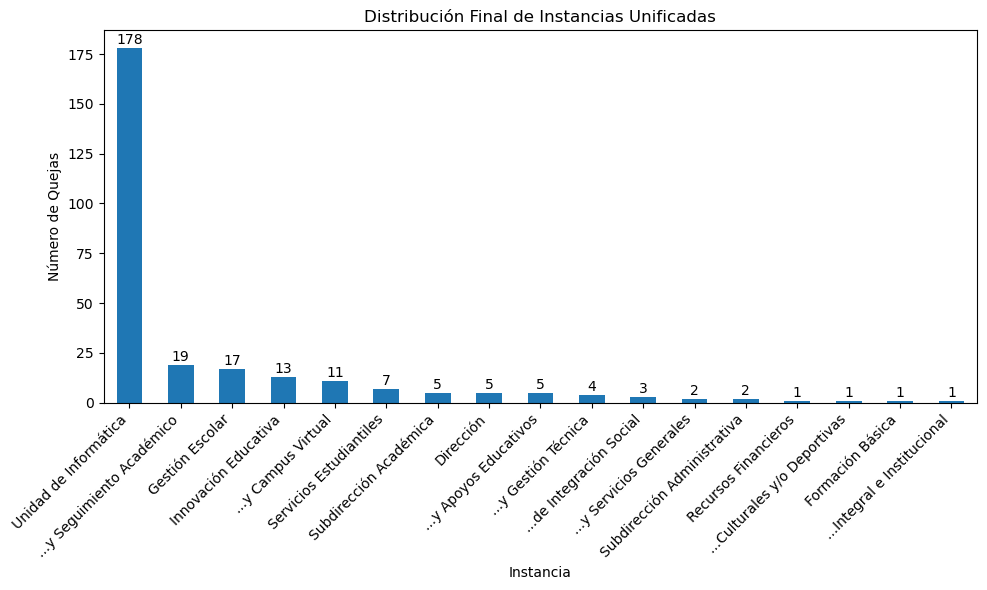

In [54]:
# Aplicamos el proceso completo de mapeo al dataframe original
# Paso 1: Transformar (eliminar prefijos)
# Paso 2: Mapear (unificar etiquetas similares)
# Paso 3: Sustituir en el dataframe original

# Aplicamos la transformación y mapeo a las instancias originales
df_relevante["Instancia_Unificada"] = (
    df_relevante["Instancia"]
    .apply(transformar_etiqueta)  # Eliminar prefijos
    .apply(mapear_etiqueta)       # Unificar etiquetas
)

# Mostramos algunos ejemplos del mapeo
print("Ejemplos de mapeo realizado:")
print(df_relevante[["Instancia", "Instancia_Unificada"]].drop_duplicates().head(10))
print(f"\nEtiquetas originales únicas: {df_relevante['Instancia'].nunique()}")
print(f"Etiquetas unificadas únicas: {df_relevante['Instancia_Unificada'].nunique()}")
print(f'Etiquetas finales: \n{df_relevante["Instancia_Unificada"].unique()}')

# Comprobamos con la distribución final
instancia_counts_final = df_relevante["Instancia_Unificada"].value_counts()
fig, ax = graficar_distribucion(
    datos=instancia_counts_final,
    titulo="Distribución Final de Instancias Unificadas",
    xlabel="Instancia",
    ylabel="Número de Quejas",
    n_palabras=3,
    figsize=(10, 6)
)
plt.show()

In [55]:
# Distribución de los datos en texto:

for instancia, count in instancia_counts_final.items():
    print(f"- {instancia}: {count}")

- Unidad de Informática: 178
- Evaluación y Seguimiento Académico: 19
- Gestión Escolar: 17
- Innovación Educativa: 13
- Tecnología Educativa y Campus Virtual: 11
- Servicios Estudiantiles: 7
- Subdirección Académica: 5
- Dirección: 5
- Extensión y Apoyos Educativos: 5
- Coordinación de Enlace y Gestión Técnica: 4
- Unidad Politécnica de Integración Social: 3
- Recursos Materiales y Servicios Generales: 2
- Subdirección Administrativa: 2
- Recursos Financieros: 1
- Actividades Culturales y/o Deportivas: 1
- Formación Básica: 1
- Formación Integral e Institucional: 1


# Selección de los mejores comentarios para la UDI

Para seleccionar los 32 mejores de la Unidad de Informática (178 ejemplos), la estrategia estándar de la industria y la más elegante es el Clustering por K-Means sobre Embeddings.

1. La Estrategia: K-Means Diversity Sampling
En lugar de "podar", lo que hacemos es "mapear el territorio".

2. Agrupamiento: Divides los 178 comentarios en 32 grupos (clusters) usando K-Means. Esto obliga al algoritmo a encontrar las 32 "temáticas" o "tipos de quejas/peticiones" diferentes que existen en esos datos.

3. Selección del Centroide: De cada uno de los 32 grupos, seleccionas el comentario que esté más cerca del centro (el representante más puro del grupo).


In [56]:
# Filtrar los comentarios de la Unidad de Informática
df_udi = df_relevante[df_relevante["Instancia_Unificada"] == "Unidad de Informática"].copy()

print(f"Total de comentarios antes del filtrado: {len(df_udi)}")

# Renombramos la columna para simplificar
df_udi = df_udi.rename(columns={"Detalles de la queja, sugerencia o felicitación": "Comentario"})

# Filtrar comentarios con palabras demasiado pequeñas
def filtrar_comentarios_validos(comentario, min_palabras=3, min_longitud_palabra=2):
    """
    Filtra comentarios que contengan suficientes palabras significativas.
    
    Parámetros:
    - min_palabras: Número mínimo de palabras que debe tener el comentario
    - min_longitud_palabra: Longitud mínima de cada palabra para ser considerada válida
    """
    if pd.isna(comentario) or not isinstance(comentario, str):
        return False
    
    # Dividir en palabras y filtrar las que son demasiado cortas
    palabras = comentario.split()
    palabras_validas = [p for p in palabras if len(p) >= min_longitud_palabra]
    
    # Verificar que tenga suficientes palabras válidas
    return len(palabras_validas) >= min_palabras

# Aplicar filtro
df_udi = df_udi[df_udi["Comentario"].apply(filtrar_comentarios_validos)].reset_index(drop=True)

print(f"Total de comentarios después del filtrado: {len(df_udi)}")
print(f"Comentarios eliminados: {len(df_relevante[df_relevante['Instancia_Unificada'] == 'Unidad de Informática']) - len(df_udi)}")
print(f"\nPrimeros comentarios:")
print(df_udi.head())

Total de comentarios antes del filtrado: 178
Total de comentarios después del filtrado: 83
Comentarios eliminados: 95

Primeros comentarios:
                                          Comentario              Instancia  \
0               No hay internet en algunas máquinas   Unidad de Informática   
1                              Me gustó los equipos   Unidad de Informática   
2  El chico siempre pide llenar la encuesta y me ...  Unidad de Informática   
3                                Ninguna, todo bien   Unidad de Informática   
4  Las computadoras no tienen internet y se tarda...  Unidad de Informática   

     Instancia_Unificada  
0  Unidad de Informática  
1  Unidad de Informática  
2  Unidad de Informática  
3  Unidad de Informática  
4  Unidad de Informática  


In [57]:
# Generar embeddings usando sentence-transformers (modelo multilingual)
from sentence_transformers import SentenceTransformer
import numpy as np

# Usamos un modelo multilingual optimizado para español
modelo_embedding = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Generamos embeddings para todos los comentarios
print("Generando embeddings para los comentarios...")
comentarios = df_udi["Comentario"].tolist()
embeddings = modelo_embedding.encode(comentarios, show_progress_bar=True)

print(f"Dimensión de embeddings: {embeddings.shape}")
print(f"Total de comentarios embeddeados: {len(embeddings)}")

Generando embeddings para los comentarios...


Batches: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s]

Dimensión de embeddings: (83, 384)
Total de comentarios embeddeados: 83


In [58]:
# Aplicar K-Means clustering con 32 clusters
from sklearn.cluster import KMeans

# Número de clusters = número de comentarios que queremos seleccionar
n_clusters = 32

print(f"Aplicando K-Means con {n_clusters} clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(embeddings)

# Obtener las etiquetas de cluster para cada comentario
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

print(f"Clustering completado")
print(f"Distribución de comentarios por cluster:")
unique, counts = np.unique(cluster_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} comentarios")

c:\Users\Joni\.conda\envs\noticias-nlp\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Aplicando K-Means con 32 clusters...
Clustering completado
Distribución de comentarios por cluster:
  Cluster 0: 4 comentarios
  Cluster 1: 13 comentarios
  Cluster 2: 7 comentarios
  Cluster 3: 1 comentarios
  Cluster 4: 2 comentarios
  Cluster 5: 3 comentarios
  Cluster 6: 3 comentarios
  Cluster 7: 4 comentarios
  Cluster 8: 2 comentarios
  Cluster 9: 2 comentarios
  Cluster 10: 1 comentarios
  Cluster 11: 3 comentarios
  Cluster 12: 2 comentarios
  Cluster 13: 1 comentarios
  Cluster 14: 4 comentarios
  Cluster 15: 7 comentarios
  Cluster 16: 3 comentarios
  Cluster 17: 1 comentarios
  Cluster 18: 2 comentarios
  Cluster 19: 2 comentarios
  Cluster 20: 1 comentarios
  Cluster 21: 1 comentarios
  Cluster 22: 2 comentarios
  Cluster 23: 1 comentarios
  Cluster 24: 1 comentarios
  Cluster 25: 1 comentarios
  Cluster 26: 3 comentarios
  Cluster 27: 1 comentarios
  Cluster 28: 2 comentarios
  Cluster 29: 1 comentarios
  Cluster 30: 1 comentarios
  Cluster 31: 1 comentarios


In [59]:
# Seleccionar el comentario más cercano al centroide de cada cluster
from scipy.spatial.distance import cdist

# Calcular distancias de cada punto a su centroide
indices_seleccionados = []

for i in range(n_clusters):
    # Obtener todos los índices de comentarios en este cluster
    indices_cluster = np.where(cluster_labels == i)[0]
    
    # Obtener embeddings de comentarios en este cluster
    embeddings_cluster = embeddings[indices_cluster]
    
    # Calcular distancias al centroide
    distancias = cdist([centroids[i]], embeddings_cluster, metric='euclidean')[0]
    
    # Seleccionar el índice del comentario más cercano
    idx_mas_cercano = indices_cluster[np.argmin(distancias)]
    indices_seleccionados.append(idx_mas_cercano)

print(f"Total de comentarios seleccionados: {len(indices_seleccionados)}")
print(f"Índices seleccionados: {sorted(indices_seleccionados)}")

Total de comentarios seleccionados: 32
Índices seleccionados: [0, 2, 3, 14, 16, 17, 18, 19, 20, 27, 28, 32, 33, 34, 35, 40, 42, 45, 49, 54, 56, 59, 65, 67, 68, 71, 73, 74, 78, 79, 80, 81]


In [60]:
# Crear dataframe con los comentarios seleccionados
df_seleccionados = df_udi.iloc[indices_seleccionados].copy()

# Agregar información del cluster al que pertenece
df_seleccionados['Cluster'] = [cluster_labels[i] for i in indices_seleccionados]

# Ordenar por cluster para mejor organización
df_seleccionados = df_seleccionados.sort_values('Cluster').reset_index(drop=True)

print(f"Comentarios seleccionados: {len(df_seleccionados)}")
print("\nPrimeros 5 comentarios seleccionados:")
print(df_seleccionados[['Cluster', 'Comentario', 'Instancia_Unificada']].head())

Comentarios seleccionados: 32

Primeros 5 comentarios seleccionados:
   Cluster                                         Comentario  \
0        0                   Se necesita mejorar el internet    
1        1                                 muy bien servicio    
2        2               No hay internet en algunas máquinas    
3        3  El servicio se llevo correctamente\nComo unico...   
4        4  Las máquinas no cuentan con Linux y se va a ca...   

     Instancia_Unificada  
0  Unidad de Informática  
1  Unidad de Informática  
2  Unidad de Informática  
3  Unidad de Informática  
4  Unidad de Informática  


In [62]:
# Preparar el dataset final: UDI filtrados + todas las demás categorías
# 1. Los 32 comentarios seleccionados de UDI
df_udi_seleccionados = df_seleccionados.copy()

# 2. Todos los comentarios de las demás instancias (no UDI)
df_otros = df_relevante[df_relevante["Instancia_Unificada"] != "Unidad de Informática"].copy()
df_otros = df_otros.rename(columns={"Detalles de la queja, sugerencia o felicitación": "Comentario"})
df_otros['Cluster'] = -1  # Marcar con -1 los no clusterizados

print(f"Comentarios de UDI seleccionados: {len(df_udi_seleccionados)}")
print(f"Comentarios de otras categorías: {len(df_otros)}")

# 3. Combinar ambos datasets
df_final = pd.concat([df_udi_seleccionados, df_otros], ignore_index=True)

print(f"\n📊 Dataset antes del preprocesamiento:")
print(f"Total de comentarios: {len(df_final)}")

# 4. PREPROCESAMIENTO DE TEXTOS
def preprocesar_comentario(texto):
    """
    Limpia el comentario eliminando saltos de línea.
    """
    if pd.isna(texto) or not isinstance(texto, str):
        return texto
    
    # Eliminar saltos de línea y espacios múltiples
    texto_limpio = texto.replace('\n', ' ').replace('\r', ' ')
    texto_limpio = ' '.join(texto_limpio.split())  # Eliminar espacios múltiples
    
    return texto_limpio

def es_comentario_valido(texto):
    """
    Valida si el comentario debe mantenerse según criterios de filtrado.
    """
    if pd.isna(texto) or not isinstance(texto, str):
        return False
    
    # Convertir a minúsculas para comparación
    texto_lower = texto.lower().strip()
    
    # Filtro 1: Vacío o solo espacios
    if len(texto_lower) == 0:
        return False
    
    # Filtro 2: Contiene "ninguno", "ninguna", o solo "no"
    if texto_lower in ['ninguno', 'ninguna', 'no', 'ninguno.', 'ninguna.', 'no.', 'queja', 'nada']:
        return False
    
    # Filtro 3: No tiene ninguna letra del abecedario
    if not any(c.isalpha() for c in texto):
        return False
    
    # Filtro 4: Solo tiene consonantes (sin vocales)
    vocales = set('aeiouáéíóúAEIOUÁÉÍÓÚ')
    letras = [c for c in texto if c.isalpha()]
    if letras and not any(c in vocales for c in letras):
        return False
    
    return True

# Aplicar limpieza de saltos de línea
df_final['Comentario'] = df_final['Comentario'].apply(preprocesar_comentario)

# Aplicar filtros de validación
print("\nAplicando filtros de validación...")
df_final_original = len(df_final)
df_final = df_final[df_final['Comentario'].apply(es_comentario_valido)].reset_index(drop=True)
comentarios_eliminados = df_final_original - len(df_final)

print(f"Comentarios eliminados por filtros: {comentarios_eliminados}")
print(f"\n📊 Dataset final después del preprocesamiento:")
print(f"Total de comentarios: {len(df_final)}")
print(f"Distribución por instancia:")
print(df_final['Instancia_Unificada'].value_counts())

# Guardar el dataset completo
archivo_salida = carpeta_raiz / "comentarios_por_departamento.csv"
df_final.to_csv(archivo_salida, index=False, encoding='utf-8-sig')

print(f"\n✓ Archivo guardado exitosamente en: {archivo_salida}")
print(f"✓ Total de comentarios guardados: {len(df_final)}")
print(f"✓ Columnas: {list(df_final.columns)}")

Comentarios de UDI seleccionados: 32
Comentarios de otras categorías: 97

📊 Dataset antes del preprocesamiento:
Total de comentarios: 129

Aplicando filtros de validación...
Comentarios eliminados por filtros: 23

📊 Dataset final después del preprocesamiento:
Total de comentarios: 106
Distribución por instancia:
Instancia_Unificada
Unidad de Informática                        32
Gestión Escolar                              16
Evaluación y Seguimiento Académico           11
Tecnología Educativa y Campus Virtual        11
Servicios Estudiantiles                       7
Innovación Educativa                          5
Extensión y Apoyos Educativos                 4
Dirección                                     4
Subdirección Académica                        4
Unidad Politécnica de Integración Social      3
Coordinación de Enlace y Gestión Técnica      2
Recursos Materiales y Servicios Generales     2
Subdirección Administrativa                   2
Actividades Culturales y/o Deportivas     

# Distribución final

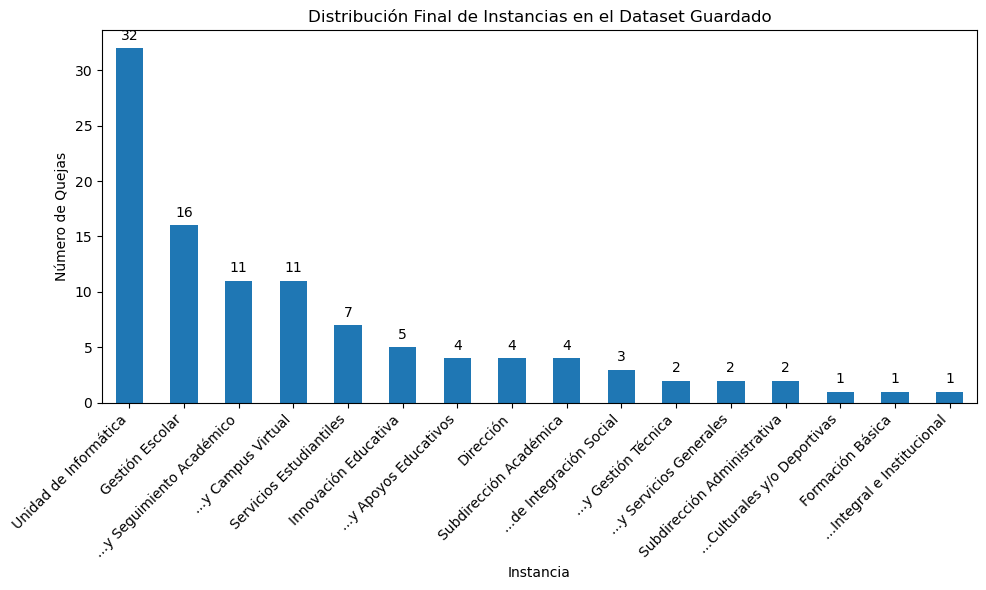

In [63]:
instancia_counts_final = df_final["Instancia_Unificada"].value_counts()
fig, ax = graficar_distribucion(
    datos=instancia_counts_final,
    titulo="Distribución Final de Instancias en el Dataset Guardado",
    xlabel="Instancia",
    ylabel="Número de Quejas",
    n_palabras=3,
    figsize=(10, 6)
)
plt.show()
